In [1]:
# hello my name faramawicho no testing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


In [2]:
merged_df= pd.read_csv('GPA2.csv')

In [3]:
merged_df

,gpa,SAT,athlete,hsize,hsrank,hsperc,female
0,2.04,920,1,10,4,40.000000,1
1,4.00,1170,0,940,191,20.319150,0
2,1.78,810,1,119,42,35.294120,0
3,2.42,940,0,571,252,44.133100,0
4,2.61,1180,0,214,86,40.186920,0
...,...,...,...,...,...,...,...
4130,2.24,990,0,233,89,38.197430,1
4131,2.46,900,0,10,2,20.000000,1
4132,4.00,1340,0,45,1,2.222222,0
4133,2.83,980,0,35,23,65.714290,1


In [4]:
success =[]
for i in merged_df["gpa"]:
    if(i >= (3)):
        success.append(True)
    else:
        success.append(False)

merged_df.insert(7,"Success", success);
merged_df

,gpa,SAT,athlete,hsize,hsrank,hsperc,female,Success
0,2.04,920,1,10,4,40.000000,1,False
1,4.00,1170,0,940,191,20.319150,0,True
2,1.78,810,1,119,42,35.294120,0,False
3,2.42,940,0,571,252,44.133100,0,False
4,2.61,1180,0,214,86,40.186920,0,False
...,...,...,...,...,...,...,...,...
4130,2.24,990,0,233,89,38.197430,1,False
4131,2.46,900,0,10,2,20.000000,1,False
4132,4.00,1340,0,45,1,2.222222,0,True
4133,2.83,980,0,35,23,65.714290,1,False


In [5]:
normalizedColumns = ['SAT', 'hsize', 'hsrank', 'hsperc'];
merged_df[normalizedColumns] = merged_df[normalizedColumns].apply(lambda x: (x-x.mean())/x.std())

merged_df

,gpa,SAT,athlete,hsize,hsrank,hsperc,female,Success
0,2.04,-0.791295,1,-1.554832,-0.754655,1.253608,1,False
1,4.00,1.001820,0,3.803029,2.138462,0.065783,0,True
2,1.78,-1.580265,1,-0.926868,-0.166749,0.969588,0,False
3,2.42,-0.647846,0,1.677168,3.082206,1.503059,0,False
4,2.61,1.073545,0,-0.379560,0.513985,1.264890,0,False
...,...,...,...,...,...,...,...,...
4130,2.24,-0.289223,0,-0.270098,0.560398,1.144815,1,False
4131,2.46,-0.934744,0,-1.554832,-0.785597,0.046521,1,False
4132,4.00,2.221138,0,-1.353193,-0.801068,-1.026446,0,True
4133,2.83,-0.360947,0,-1.410804,-0.460702,2.805578,1,False


Correlation Matrix:
              gpa       SAT   athlete     hsize    hsrank    hsperc    female
gpa      1.000000  0.410569 -0.092137 -0.026595 -0.333762 -0.428407  0.105971
SAT      0.410569  1.000000 -0.185102  0.063906 -0.177764 -0.283241 -0.153724
athlete -0.092137 -0.185102  1.000000  0.049433  0.188374  0.204964 -0.097164
hsize   -0.026595  0.063906  0.049433  1.000000  0.607410 -0.036213 -0.003756
hsrank  -0.333762 -0.177764  0.188374  0.607410  1.000000  0.611868 -0.104916
hsperc  -0.428407 -0.283241  0.204964 -0.036213  0.611868  1.000000 -0.146474
female   0.105971 -0.153724 -0.097164 -0.003756 -0.104916 -0.146474  1.000000


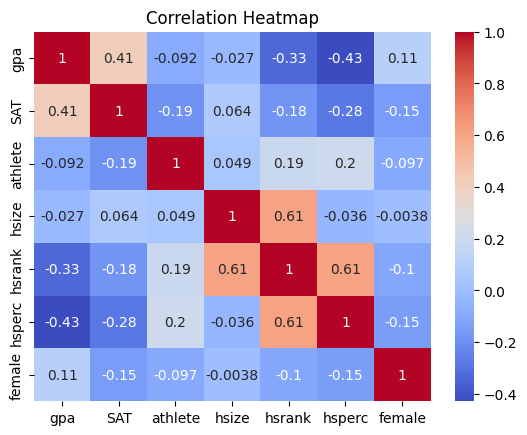

In [6]:
# Generate the correlation matrix
correlation_matrix = merged_df[['gpa', 'SAT', 'athlete','hsize','hsrank','hsperc','female']].corr()

# Print out the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [7]:
from sklearn.model_selection import cross_val_score

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']

# Try a different random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))


Cross-validation RMSE scores: [0.52185647 0.53796659 0.57447333 0.56598062 0.56143505]
Mean CV RMSE: 0.5523424141968496
Train RMSE: 0.5537237876351425
Test RMSE: 0.5426327348911839


In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']  # Assuming 'gpa' is the continuous variable to predict

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Train model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))


Cross-validation RMSE scores: [0.75831049 0.76801972 0.8022856  0.78870758 0.74084848]
Mean CV RMSE: 0.7716343729013077
Train RMSE: 0.038746781305117016
Test RMSE: 0.7514570187893865


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))


Cross-validation RMSE scores: [0.55188725 0.55922149 0.58558882 0.59034617 0.57749016]
Mean CV RMSE: 0.5729067777363896
Train RMSE: 0.21467317444864917
Test RMSE: 0.5562511447967956


In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Train model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))


Cross-validation RMSE scores: [0.52611688 0.53006522 0.56496192 0.55988666 0.5595372 ]
Mean CV RMSE: 0.5481135754712088
Train RMSE: 0.5033943360007342
Test RMSE: 0.5396110565142763


In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['Success']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
model = KNeighborsClassifier(n_neighbors= 500)

model.fit(X_train,y_train)

print(model.score(X_test, y_test))

0.7671232876712328


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['Success']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)


model = LogisticRegression(random_state=0,C=0.01,fit_intercept=True).fit(X_train,y_train)

print(model.score(X_test, y_test))

model.predict(X_test)


# # Cross-validation
# cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
# cv_rmse = np.sqrt(-cv_scores)
# print("Cross-validation RMSE scores:", cv_rmse)
# print("Mean CV RMSE:", np.mean(cv_rmse))

# # Predict and evaluate
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
# print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))


0.7695406929895245


array([False, False, False, ...,  True,  True, False])

In [13]:
#0.7663174858984689
#0.7663174858984689

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


svm_model = SVC(kernel='rbf', probability=True)  

svm_model.fit(X_train_scaled, y_train)


y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7630560928433269
